In [92]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import math
import torch.nn.functional as F
from tqdm import tqdm
from transformer import Transformer
from mnist_classifier import MNISTClassifier
import time

In [162]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [163]:
def to_tokens(text, c_to_i):
    
    res = []
    
    for c in text:
        res.append(c_to_i[c])
        
    return res

In [164]:
def from_tokens(tokens, i_to_c):
    
    res = []
    
    for t in tokens:
        res.append(i_to_c[t])
        
    return "".join(res)

In [165]:
class TokenDataset(Dataset):
    def __init__(self, tokens, context_size):
        
        self.context_size = context_size
        self.tokens = torch.tensor(tokens)

    def __len__(self):
        return len(self.tokens) - self.context_size - 1

    def __getitem__(self, idx):
        x = self.tokens[idx:(idx + self.context_size)]
        y = self.tokens[(idx + 1):(idx + self.context_size + 1)]
        
        return x, y

In [166]:
def get_dataset_and_dicts(filename, context_size):
    
    with open(filename, "r") as f:
        text = f.read()
    
    chars = list(sorted(set(text)))
    
    print(f"context size = {context_size}")
    print(f"#symbols = {len(chars)}")
    
    c_to_i = {c:i for i, c in enumerate(chars)}
    i_to_c = {i:c for i, c in enumerate(chars)}
    
    tokens = to_tokens(text, c_to_i)
    
    print(f"#tokens in text = {len(tokens)}")
    
    return TokenDataset(tokens, context_size), c_to_i, i_to_c

In [167]:
context_size = 152
token_dataset, c_to_i, i_to_c = get_dataset_and_dicts("mnist10k_as_text.txt", context_size=context_size)

context size = 152
#symbols = 74
#tokens in text = 1529999


In [168]:
train_set, val_set, test_set = torch.utils.data.random_split(token_dataset, [0.9, 0.05, 0.05])

In [169]:
batch_size = 128

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=True, batch_size=batch_size)

In [170]:
# taken from: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [171]:
def train(transformer, train_loader, val_loader, n_epochs,
          optimizer=None,
          lr_scheduler=None,
          early_stopper=None,
          metrics_per_epoch=10
         ):
    
    transformer = transformer.to(device)
    
    if optimizer is None:
        optimizer = torch.optim.Adam(transformer.parameters(), lr=3e-4)
        print("Using default optimizer")
        
    if early_stopper is None:
        early_stopper = EarlyStopper(patience=3, min_delta=1e-2)
        print("Using default early stopper")
        
    if lr_scheduler is None:
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                                  factor=0.3, patience=3, min_lr=1e-5,
                                                                  threshold=1e-3
                                                                 )
        print("Using default LR scheduler")
    
    # label smoothing deactivated for now
    criterion_train = nn.CrossEntropyLoss(label_smoothing=0.0)
    criterion_test = nn.CrossEntropyLoss()
    
    train_losses_over_epochs = []
    val_losses_over_epochs = []
    
    metrics_every = len(train_loader) // metrics_per_epoch
    in_between_epochs = []
    in_between_metrics = []
    
    for epoch_idx in range(n_epochs):
        
        train_losses_this_batch = []
        transformer.train()
        
        with tqdm(train_loader, desc=f"Epoch {epoch_idx + 1}/{n_epochs}", unit="batch") as tepoch:
            for batch_idx, (batch_x, batch_y) in enumerate(tepoch):

                # to GPU
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                logits = transformer(batch_x)

                logits = logits.transpose(1, 2)

                loss = criterion_train(logits, batch_y)

                train_losses_this_batch.append(loss.item())

                if batch_idx % metrics_every == 0:
                    in_between_loss = np.mean(np.array(train_losses_this_batch))
                    in_between_metrics.append(in_between_loss)
                    in_between_epochs.append(epoch_idx + (batch_idx / len(train_loader)))

                    tepoch.set_postfix(avg_loss=in_between_loss)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
        train_loss_this_epoch = np.mean(np.array(train_losses_this_batch))
        train_losses_over_epochs.append(train_loss_this_epoch)
        
        # for early stopping
        val_losses_this_batch = []
        
        transformer.eval()
        
        with torch.no_grad():
            for batch_idx, (batch_x, batch_y) in enumerate(val_loader):

                # to GPU
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                logits = transformer(batch_x)
                
                logits = logits.transpose(1, 2)

                loss = criterion_test(logits, batch_y)

                val_losses_this_batch.append(loss.item())
        
        val_loss_this_epoch = np.mean(np.array(val_losses_this_batch))
        val_losses_over_epochs.append(val_loss_this_epoch)
        print(f"{epoch_idx}. avg. train loss = {train_loss_this_epoch}, avg. val loss = {val_loss_this_epoch}")
        
        should_stop = early_stopper.early_stop(val_loss_this_epoch)
        lr_scheduler.step(val_loss_this_epoch)
        
        if should_stop:
            print(f"stopping early (val. loss did not decrease for {early_stopper.patience})")
            break
        
    return train_losses_over_epochs, in_between_epochs, in_between_metrics, val_losses_over_epochs

In [174]:
n_symbols = len(c_to_i.keys())

transformer = Transformer(n_symbols, context_size, d_model = 256, n_heads = 8, n_layers=8, device=device)

In [175]:
optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-4)

In [176]:
train_losses, in_between_epochs, in_between_metrics, val_losses =\
train(transformer, train_loader, val_loader, n_epochs=1, optimizer=optimizer, metrics_per_epoch=100)

Using default early stopper
Using default LR scheduler


Epoch 1/1: 100%|███████| 10757/10757 [40:20<00:00,  4.44batch/s, avg_loss=0.531]


0. avg. train loss = 0.5303010509294948, avg. val loss = 0.426700659021486


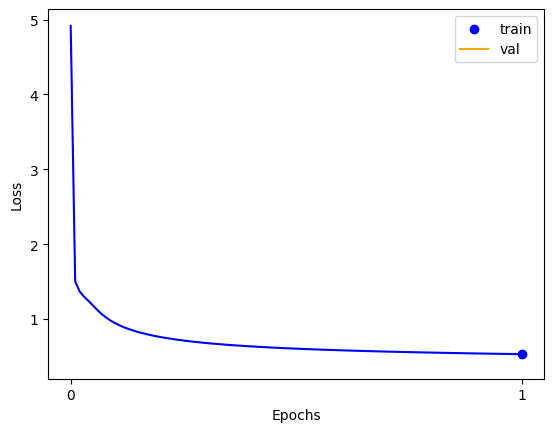

In [177]:
epoch_list = np.arange(len(train_losses)) + 1.0
plt.scatter(epoch_list, train_losses, label="train", c="blue")
plt.plot(in_between_epochs, in_between_metrics, c="blue")
plt.plot(epoch_list, val_losses, label="val", c="orange")
plt.xlabel("Epochs")
plt.xticks(np.arange(len(train_losses) + 1))
plt.ylabel("Loss")
plt.legend()
plt.show()

In [178]:
def get_text_samples(response, i_to_c):

    text_samples = []

    for row in response:
        text_sample = ''.join([i_to_c[token.item()] for token in row])
        text_samples.append(text_sample)
    
    return text_samples

In [179]:
def from_string(string):
    
    end_pos = string.find(")")
    chars = list(string)
    
    if end_pos > -1:
        for i in range(end_pos, len(string)):
            chars[i] = ":"
    
    chunk_size = 6
    
    width = height = int(math.sqrt(len(chars)))
    
    bitmap = np.zeros((30, 30))
    
    chars_per_row = 30 // chunk_size
    
    for idx, c in enumerate(chars):
        
        row_idx = (idx // chars_per_row)
        col_idx = idx % chars_per_row
        
        integer_value = max(0, ord(c) - 58)
        
        bitstring = format(integer_value, '06b')  # Convert to bitstring without leading '0b'
        bit_list = [int(bit) for bit in bitstring]
        
        y_coord = row_idx
        x_coord = (chunk_size * col_idx)
        
        bitmap[y_coord, x_coord:x_coord + chunk_size] = np.array(bit_list)[:chunk_size]
    
    return bitmap

In [180]:
mnist_classifier = MNISTClassifier()
mnist_classifier.load_model("mnist_classifier.pth")

Model loaded from mnist_classifier.pth


In [230]:
def query_and_plot(transformer,
                   c_to_i, i_to_c,
                   prompt, n_samples,
                   beta,
                   show_top_k=-1, classifier=None, beta_c=1.0):
    
    assert (show_top_k == -1 or classifier is not None), "show_top_k requires ranking by classifier"
    
    sampling_start_time = time.time()
    
    response = transformer.sample(prompt=prompt, n_tokens=150,
                                  n_samples=n_samples, c_to_i=c_to_i, beta=beta)
    
    sampling_end_time = time.time()
    print(f"Sampling time: {sampling_end_time - sampling_start_time:.2f}s")
    
    # Convert the response to text samples
    texts = get_text_samples(response, i_to_c)
    
    # Convert texts to numpy arrays
    images = np.array([from_string(text) for text in texts])
    conversion_end_time = time.time()
    
    print(f"Conversion time: {conversion_end_time - sampling_end_time:.2f}s")
    
    torch_images = torch.tensor(images).unsqueeze(1).float()
    
    if show_top_k != -1:
        logits = classifier(torch_images) / beta_c
        preds = F.softmax(logits, dim=1)
        
        # 0 to 9
        desired_class = int(prompt)
        #print(f"Desired class: {desired_class}")
        
        # sort descending!!!
        res = torch.argsort(-preds[:, desired_class]).numpy()
        
        images = images[res][:show_top_k]
        
    ranking_time_end = time.time()
    print(f"Ranking time: {ranking_time_end - conversion_end_time:.2f}s")
    
    # Calculate the number of rows needed to display the images
    nrows = (len(images) + 3) // 4  # Ensure there's enough rows, rounding up
    fig, axs = plt.subplots(nrows=nrows, ncols=4, figsize=(20, nrows*5))  # Each image will have space allocated in the grid
    
    # Flatten the axes array for easy iteration
    axs = axs.flatten()
    
    # Loop through the images and plot them
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')  # Turn off the axis to only show the image
    
    # Turn off any unused subplots
    for i in range(len(images), len(axs)):
        axs[i].axis('off')
    
    plt.show()
    
    display_time_end = time.time()
    print(f"Display time: {display_time_end - ranking_time_end:.2f}s")

In [231]:
#transformer.save_model("mnist_transformer_1e_10k.pth")

In [228]:
#transformer.load_model("mnist_transformer.pth")

Prompt: 9
Prompt tokens: [11]
Sampling time: 3.12s
Conversion time: 0.14s
Ranking time: 0.00s


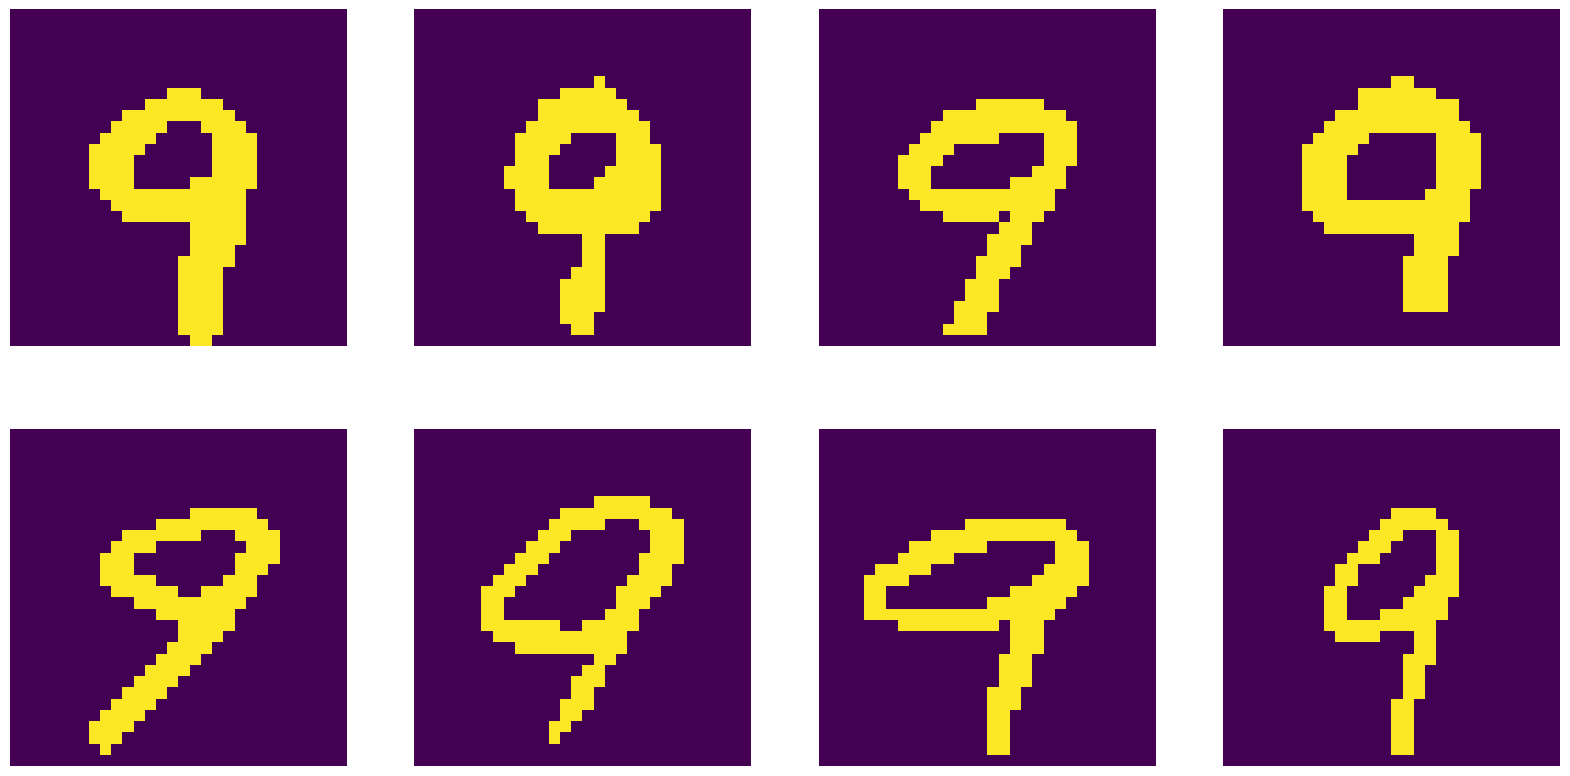

Display time: 0.33s


In [243]:
query_and_plot(transformer, c_to_i, i_to_c, prompt="9",
               n_samples = 64, beta=0.8,
              show_top_k=8, classifier=mnist_classifier, beta_c = 0.9)